# Logistic Regression with a Neural Network mindset

This notebook shows how to build a logistic regression classifier to recognize  cats with a Neural Network mindset.

## Table of Contents
- [1 - Packages](#1)
- [2 - Overview of the Problem set](#2)
- [3 - General Architecture of the learning algorithm](#3)
- [4 - Further analysis (optional/ungraded exercise)](#4)
- [5 - Test with your own image (optional/ungraded exercise)](#5)

<a name='1'></a>
## 1 - Packages ##

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org/doc/1.20/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](https://pillow.readthedocs.io/en/stable/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
cd ..

C:\Users\cxo87\Projects\DeepLearning


In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from deeplearning.prediction import LogitPredict
from deeplearning.modelling import Model

In [4]:
def load_dataset():
    train_dataset = h5py.File("datasets/train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(
        train_dataset["train_set_x"][:]
    )  # your train set features
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:]
    )  # your train set labels

    test_dataset = h5py.File("datasets/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

<a name='2'></a>
## 2 - Overview of the Problem set ##

**Problem Statement**: a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

Goal: build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

In [5]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [1], it's a 'cat' picture.


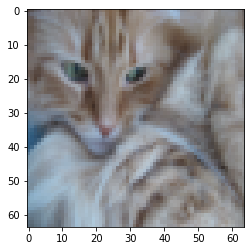

In [6]:
# Example of a picture
index = 2
plt.imshow(train_set_x_orig[index])
print(
    "y = "
    + str(train_set_y[:, index])
    + ", it's a '"
    + classes[np.squeeze(train_set_y[:, index])].decode("utf-8")
    + "' picture."
)

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

<a name='ex-1'></a>
Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [7]:
# (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig[0].shape[0]
# YOUR CODE STARTS HERE


# YOUR CODE ENDS HERE

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [8]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


# Check that the first 10 pixels of the second image are in the correct place
assert np.alltrue(
    train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]
), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(
    test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]
), "Wrong solution. Use (X.shape[0], -1).T."

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [9]:
train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

<font color='blue'>

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

In [10]:
model = Model()
model.train(
    train_set_x, train_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True
)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872


In [11]:
result = model.predict(test_set_x, test_set_y, print_cost=True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 0, you predicted that it is a "non-cat" picture.


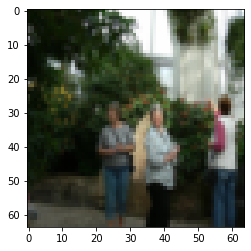

In [12]:
# Example of a picture that was wrongly classified.
index = 21
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print(
    "y = "
    + str(test_set_y[0, index])
    + ', you predicted that it is a "'
    + classes[int(result["Y_prediction_test"][0, index])].decode("utf-8")
    + '" picture.'
)

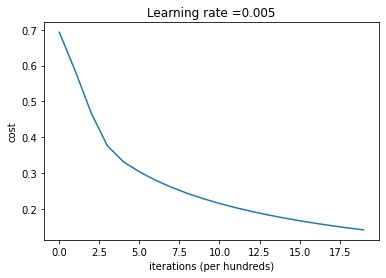

In [13]:
# Plot learning curve (with costs)
costs = np.squeeze(result["costs"])
plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title("Learning rate =" + str(result["learning_rate"]))
plt.show()

<a name='4'></a>
## 4 - Further analysis

Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



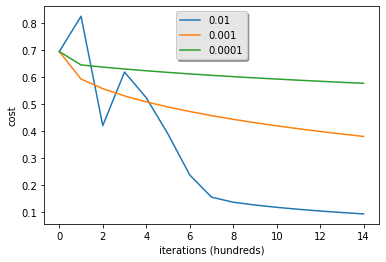

In [14]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print("Training a model with learning rate: " + str(lr))
    model = Model()
    model.train(train_set_x, train_set_y, num_iterations=1500, learning_rate=lr)
    models[str(lr)] = model.predict(test_set_x, test_set_y, print_cost=False)
    print("\n" + "-------------------------------------------------------" + "\n")

for lr in learning_rates:
    plt.plot(
        np.squeeze(models[str(lr)]["costs"]),
        label=str(models[str(lr)]["learning_rate"]),
    )

plt.ylabel("cost")
plt.xlabel("iterations (hundreds)")

legend = plt.legend(loc="upper center", shadow=True)
frame = legend.get_frame()
frame.set_facecolor("0.90")
plt.show()

<a name='5'></a>
## 5 - Test with my own image ##

In [20]:
def test_image(my_image):
    # We preprocess the image to fit your algorithm.
    fname = "images/" + my_image
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    plt.imshow(image)
    image = image / 255.0
    image = image.reshape((1, num_px * num_px * 3)).T
    my_predicted_image = LogitPredict().predict(result["w"], result["b"], image)

    print(
        "y = "
        + str(np.squeeze(my_predicted_image))
        + ', your algorithm predicts a "'
        + classes[
            int(np.squeeze(my_predicted_image)),
        ].decode("utf-8")
        + '" picture.'
    )

y = 1.0, your algorithm predicts a "cat" picture.


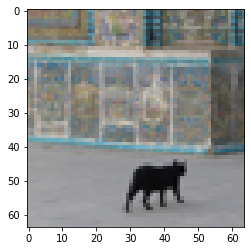

In [21]:
test_image(my_image="cat_in_iran.jpg")

y = 0.0, your algorithm predicts a "non-cat" picture.


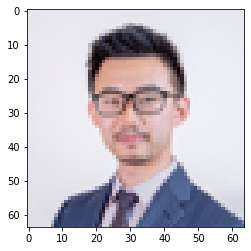

In [22]:
test_image(my_image="1561040958920.jpg")